<a href="https://www.kaggle.com/code/dllim1/end-to-end-ml-on-motor-insurance-with-xgboost?scriptVersionId=107604636" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Predicting Motor Insurance Claims and Claim Amount

**If this helped you or was interesting to you, your <span style="color:red">UPVOTES</span> would be very much appreciated – they are the source of my motivation!**

# About the dataset
The dataset contains information on policyholders of motor insurance such as the type of vehicle, vehicle value, household statistics, claim history, and more. 

In this dataset, we can obtain two targets for prediction - A binary value on whether a claim has occured, and a claim amount given that the claim has occured.

# Objectives
In this notebook, we will explore the steps required to approach the classification problem of whether or not a claim occured, from start to finish. Once we have completed the classification problem, we will repeat the steps for a regression problem to predict the numerical value of claim amounts.

The regression model is “by construction” an interpolation model.

The reason for splitting this project as two problems instead of just a regression, is to avoid predicting claims at a low amount, of perhaps only $2, which makes no sense, and the exact claim amount threshold to define that a claim occured may be subject to much debate.

Thus, by classifying whether or not a claim occured, we can then make a regression prediction thereafter, conditional on a claim occurring.

Since there is no test set provided, we will perform a simple hold-out validation as a test set. In the spirit of never having seen this artificially created test set, we will not be performing EDA on that set.

This notebook will guide us through an end-to-end process of:

1. Cleaning and Splitting Test Data
2. Exploratory Data Analysis
3. Cross Validation
4. Feature Engineering
5. Model Selection
6. Advanced Feature Transformation
7. Fitting the Model
8. Hyperparameter Optimisation
9. Predicting Test Data
10. Regression Problem

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression, Lasso

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import skew

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor

# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/car-insurance-claim-data/car_insurance_claim.csv


# 1. Cleaning and Splitting Test Data

### 1.1 Understanding the Dimensions
First, we'll look at basic descriptions of the data to understand what we're working with.

We're careful here not to explore the test data, which we have not yet split.


In [2]:
input_file = '/kaggle/input/car-insurance-claim-data/car_insurance_claim.csv' 
ori_df = pd.read_csv(input_file)
pd.set_option('display.max_columns', None)
ori_df.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


In [3]:
ori_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          10302 non-null  int64  
 1   KIDSDRIV    10302 non-null  int64  
 2   BIRTH       10302 non-null  object 
 3   AGE         10295 non-null  float64
 4   HOMEKIDS    10302 non-null  int64  
 5   YOJ         9754 non-null   float64
 6   INCOME      9732 non-null   object 
 7   PARENT1     10302 non-null  object 
 8   HOME_VAL    9727 non-null   object 
 9   MSTATUS     10302 non-null  object 
 10  GENDER      10302 non-null  object 
 11  EDUCATION   10302 non-null  object 
 12  OCCUPATION  9637 non-null   object 
 13  TRAVTIME    10302 non-null  int64  
 14  CAR_USE     10302 non-null  object 
 15  BLUEBOOK    10302 non-null  object 
 16  TIF         10302 non-null  int64  
 17  CAR_TYPE    10302 non-null  object 
 18  RED_CAR     10302 non-null  object 
 19  OLDCLAIM    10302 non-nul

In [4]:
print(f"Dataset has {ori_df.shape[0]} rows and {ori_df.shape[1]} columns")
print(f"Duplicates: {ori_df.duplicated().sum()}")
print(f"Total Missing Values: {ori_df.isna().sum().sum()}")
print(f"Number of rows with missing values: {ori_df.isna().any(axis=1).sum()}")

Dataset has 10302 rows and 27 columns
Duplicates: 1
Total Missing Values: 3004
Number of rows with missing values: 2645


Here's what these columns mean, and what effect they may hypothetically have on our target variables. This is just wild conjecture at this point, based on our logical understanding of insurance. Soon, we shall uncover the actual effects!

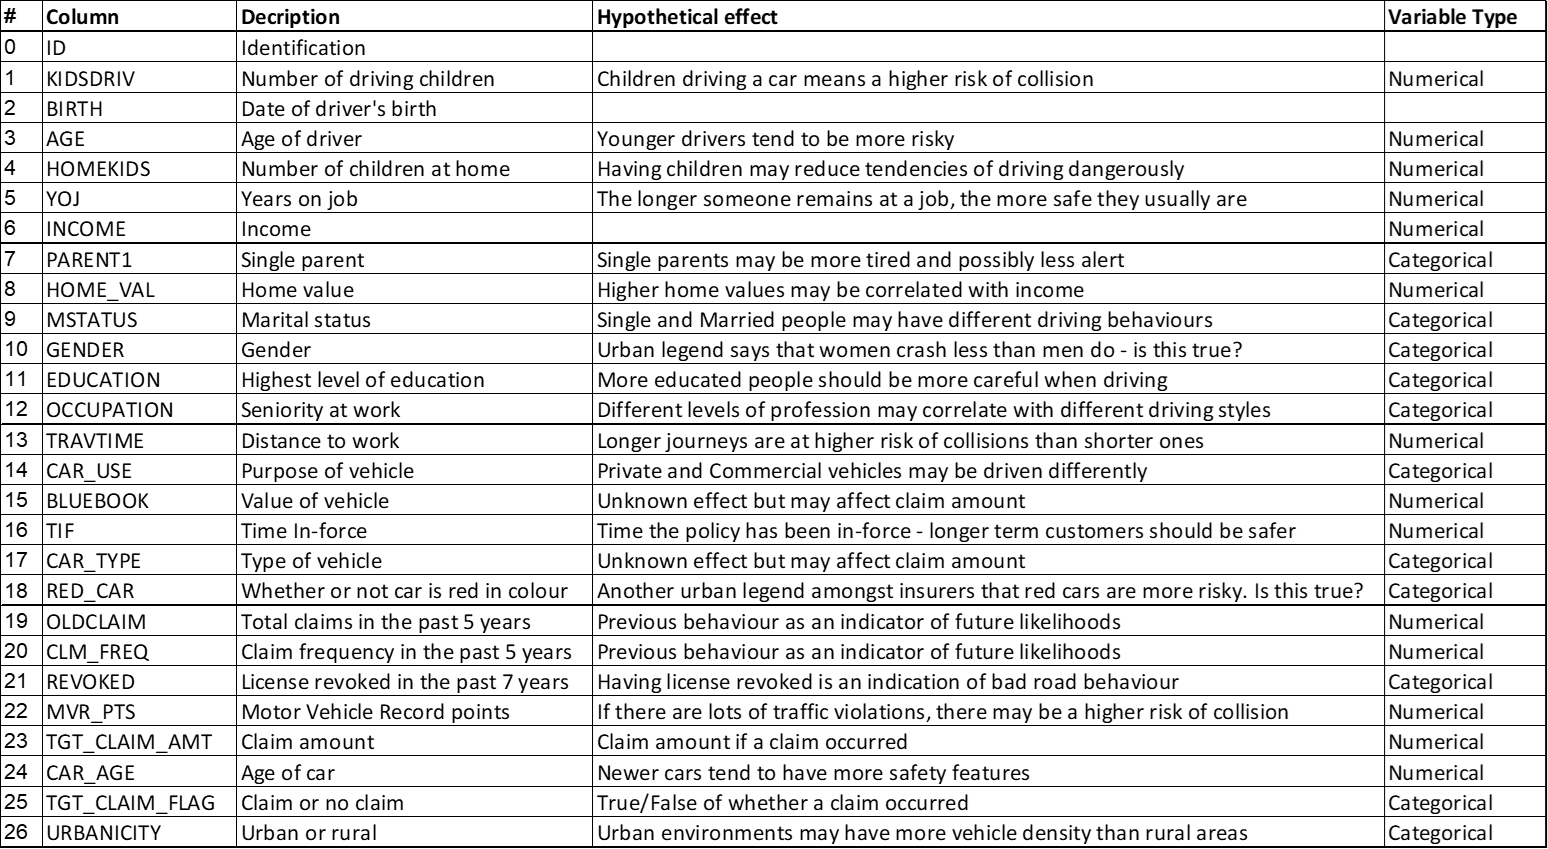

### 1.2 Performing Clean Up of Data
We have to be careful not to fundamentally change any values relative to others while keeping in mind that we should avoid any leakage as we have not yet split our test set.


These cleanups would have been performed at the source level in a production setting, but our line of work isn't perfect, so here we are!

In [5]:
# Create a Population DataFrame copy of the original
pop_df = ori_df.copy()

# Remove the duplicate we saw previously
pop_df.drop_duplicates(inplace=True) # leave this

# Convert currecy into floats
def convert_currency(df, columns: list):
    for col in columns:
        df[col] = np.where(pd.isnull(df[col]), df[col], df[col].astype('str').map(lambda x: x.replace(',','').replace('$',''))).astype('float')

# There are some values that have a prefix 'z_' that does not mean anything. Let my OCD have this one, please.
def remove_z(df, columns: list):
    for col in columns:
        df[col] = np.where(pd.isnull(df[col]), df[col], df[col].astype('str').map(lambda x: x.replace('z_','')))

currency_cols = ['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM','CLM_AMT']
z_cols = ['MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION', 'CAR_TYPE','URBANICITY']

convert_currency(pop_df, currency_cols)
remove_z(pop_df, z_cols)

# Rename our target columns with a prefix 'TGT_' so we can visually identify better.
pop_df.rename({'CLM_AMT': 'TGT_CLAIM_AMT', 'CLAIM_FLAG': 'TGT_CLAIM_FLAG'}, axis=1, inplace=True);

# These columns don't add any value. 'BIRTH' is redundant with the 'AGE' column present
pop_df.drop(['BIRTH','ID'], axis=1, inplace=True);

In [6]:
pop_df.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,TGT_CLAIM_AMT,CAR_AGE,TGT_CLAIM_FLAG,URBANICITY
0,0,60.0,0,11.0,67349.0,No,0.0,No,M,PhD,Professional,14,Private,14230.0,11,Minivan,yes,4461.0,2,No,3,0.0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449.0,No,257252.0,No,M,High School,Blue Collar,22,Commercial,14940.0,1,Minivan,yes,0.0,0,No,0,0.0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881.0,No,0.0,No,M,Bachelors,Manager,26,Private,21970.0,1,Van,yes,0.0,0,No,2,0.0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039.0,No,124191.0,Yes,F,High School,Clerical,5,Private,4010.0,4,SUV,no,38690.0,2,No,3,0.0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,NaN,No,306251.0,Yes,M,<High School,Blue Collar,32,Private,15440.0,7,Minivan,yes,0.0,0,No,0,0.0,6.0,0,Highly Urban/ Urban


In [7]:
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10301 entries, 0 to 10301
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   KIDSDRIV        10301 non-null  int64  
 1   AGE             10294 non-null  float64
 2   HOMEKIDS        10301 non-null  int64  
 3   YOJ             9753 non-null   float64
 4   INCOME          9731 non-null   float64
 5   PARENT1         10301 non-null  object 
 6   HOME_VAL        9726 non-null   float64
 7   MSTATUS         10301 non-null  object 
 8   GENDER          10301 non-null  object 
 9   EDUCATION       10301 non-null  object 
 10  OCCUPATION      9636 non-null   object 
 11  TRAVTIME        10301 non-null  int64  
 12  CAR_USE         10301 non-null  object 
 13  BLUEBOOK        10301 non-null  float64
 14  TIF             10301 non-null  int64  
 15  CAR_TYPE        10301 non-null  object 
 16  RED_CAR         10301 non-null  object 
 17  OLDCLAIM        10301 non-null 

In [8]:
pop_df.nunique()

KIDSDRIV             5
AGE                 61
HOMEKIDS             6
YOJ                 21
INCOME            8151
PARENT1              2
HOME_VAL          6334
MSTATUS              2
GENDER               2
EDUCATION            5
OCCUPATION           8
TRAVTIME           100
CAR_USE              2
BLUEBOOK          2985
TIF                 23
CAR_TYPE             6
RED_CAR              2
OLDCLAIM          3545
CLM_FREQ             6
REVOKED              2
MVR_PTS             14
TGT_CLAIM_AMT     2346
CAR_AGE             30
TGT_CLAIM_FLAG       2
URBANICITY           2
dtype: int64

In [9]:
print(f"Dataset has {ori_df.shape[0]} rows and {ori_df.shape[1]} columns")
print(f"Duplicates: {ori_df.duplicated().sum()}")
print(f"Total Missing Values: {ori_df.isna().sum().sum()}")
print(f"Number of rows with missing values: {ori_df.isna().any(axis=1).sum()}")

Dataset has 10302 rows and 27 columns
Duplicates: 1
Total Missing Values: 3004
Number of rows with missing values: 2645


In [10]:
# Let's define the categorical columns and numerical columns which will be later used as features
categorical_cols = [col for col in pop_df.columns if (pop_df[col].nunique() < 10) and 
                    (pop_df[col].dtype == "object") and
                    col not in ['TGT_CLAIM_AMT','TGT_CLAIM_FLAG']]

numerical_cols = [col for col in pop_df.columns if (pop_df[col].dtype in ['int64', 'float64']) and
                  col not in ['TGT_CLAIM_AMT','TGT_CLAIM_FLAG']]

print('Number of Numerical columns   :',len(numerical_cols))
print('Number of Categorical columns :',len(categorical_cols))

Number of Numerical columns   : 13
Number of Categorical columns : 10


#### Sense check of Targets
"Domain knowledge" time!  
> There shouldn't be any claim amount if there isn't any claim.

In [11]:
# Check for positive claims with non-zero claim amount (there shouldn't be any)
pop_df.loc[(pop_df['TGT_CLAIM_FLAG'] == False) & (pop_df['TGT_CLAIM_AMT'] > 0), ['TGT_CLAIM_FLAG','TGT_CLAIM_AMT']]

,TGT_CLAIM_FLAG,TGT_CLAIM_AMT


In [12]:
# Check for positive claims with zero claim amount (there shouldn't be any here either)
pop_df.loc[(pop_df['TGT_CLAIM_FLAG'] == True) & (pop_df['TGT_CLAIM_AMT'] <= 0), ['TGT_CLAIM_FLAG','TGT_CLAIM_AMT']]

,TGT_CLAIM_FLAG,TGT_CLAIM_AMT


Okay, now we have a base DataFrame where we can begin our work with. I'm going to have a quick chat with the Data Engineer about cleaning this up for next time! Be right back.

### 1.3 Splitting the Test Data

Now that we have a good clean set to work with, we'll assume newer data coming in will be in this form going forward.

We will then artificially select a sample for a hold-out test set, which should have proportionally the amount of positive claims, so that there is enough test data for the claim amount problem in the second half.

Since we're unable to generate any new test data, we'll select a sample that is proportional to the population data, using stratified methods. This is to avoid sampling errors in the target claim amount, which we'll see later on the training data.

Since this will be (semi)randomly selected once and for all, the distribution of the test set completely is out of control and out of reach of the models. This would also prevent any leakage further down the line.

###### Stratified Hold Out
We've established that we want to perform a stratified split, as a hold out for the test set.

We can stratify on the 0's and 1's of `TGT_CLAIM_FLAG`, but it could produce greater sampling errors for `TGT_CLAIM_AMT`.

So, the best strategy here is to stratify on the `TGT_CLAIM_AMT`

To perform stratification on numerical targets/regression problems, manual folding may be required.

We should split the numerical values in into bins for stratification. But how many bins?

We'll use Sturges' Formula to find the optimal number of bins:
https://en.wikipedia.org/wiki/Histogram#Sturges'_formula

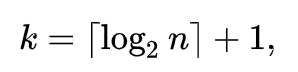

In [13]:
def make_stratified_k_folds(df,tgt_col:str,n_splits):
    # Randomise and reset index for splitting
    df = df.sample(frac=1,random_state=0).reset_index(drop=True)
    n_rows = df.shape[0]
    
    # Calculate k in Sturges Formula
    n_bins = int(np.floor(np.log2(n_rows) + 1))
    
    # Create bins
    df.loc[:,'bins'] = pd.cut(
        df[tgt_col], bins=n_bins, labels=False
    )
    
    skf = StratifiedKFold(n_splits=n_splits)
    for f, (t_, v_) in enumerate(skf.split(X=df, y=df['bins'].values)):
        df.loc[v_, 'kfold'] = f
        
    df = df.drop('bins',axis=1)
    return df

# Create hold-out test fold 
pre_df = make_stratified_k_folds(pop_df,'TGT_CLAIM_AMT',8)
train_df = pre_df.copy().loc[pre_df['kfold'] != 0].drop('kfold', axis=1)
test_df = pre_df.copy().loc[pre_df['kfold'] == 0].drop('kfold', axis=1)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  UserWarning,


In [14]:
# Sense check to see if distribution of TGT_CLAIM_FLAG is almost proportional, since we stratified on TGT_CLAIM_AMT
test_ratio = test_df['TGT_CLAIM_FLAG'].value_counts()[0] / test_df['TGT_CLAIM_FLAG'].value_counts()[1]
ori_ratio = pre_df['TGT_CLAIM_FLAG'].value_counts()[0] / pre_df['TGT_CLAIM_FLAG'].value_counts()[1]
print("{:.4%}".format(test_ratio / ori_ratio - 1), 'difference')

3.3985% difference


Good! That's a negligible difference, so our split is proportional. From here on, we won't touch the test data AT ALL.

All exploration and model training will be done on the training set.

# 2. Exploratory Data Analysis
### 2.1 Basic Exploration

In [15]:
train_df.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,TGT_CLAIM_AMT,CAR_AGE,TGT_CLAIM_FLAG,URBANICITY
420,0,51.0,0,NaN,72354.0,No,213346.0,Yes,M,Bachelors,Professional,44,Commercial,18110.0,1,Van,yes,2060.0,3,No,7,107586.0,3.0,1,Highly Urban/ Urban
738,0,42.0,0,10.0,NaN,No,171676.0,Yes,M,<High School,Clerical,48,Private,12600.0,1,Minivan,no,0.0,0,No,3,50033.0,6.0,1,Highly Urban/ Urban
923,2,39.0,2,13.0,92000.0,No,301965.0,Yes,M,Bachelors,Professional,50,Private,14600.0,1,Minivan,yes,6627.0,3,No,2,34302.0,1.0,1,Highly Urban/ Urban
964,1,41.0,4,8.0,175783.0,Yes,0.0,No,F,PhD,NaN,46,Commercial,21520.0,11,Pickup,no,4082.0,2,No,4,29865.0,17.0,1,Highly Urban/ Urban
994,0,39.0,0,10.0,92264.0,No,0.0,No,F,Bachelors,Professional,53,Private,22830.0,10,Sports Car,no,10011.0,1,No,1,85524.0,1.0,1,Highly Urban/ Urban


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9013 entries, 420 to 10300
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   KIDSDRIV        9013 non-null   int64  
 1   AGE             9007 non-null   float64
 2   HOMEKIDS        9013 non-null   int64  
 3   YOJ             8539 non-null   float64
 4   INCOME          8512 non-null   float64
 5   PARENT1         9013 non-null   object 
 6   HOME_VAL        8503 non-null   float64
 7   MSTATUS         9013 non-null   object 
 8   GENDER          9013 non-null   object 
 9   EDUCATION       9013 non-null   object 
 10  OCCUPATION      8431 non-null   object 
 11  TRAVTIME        9013 non-null   int64  
 12  CAR_USE         9013 non-null   object 
 13  BLUEBOOK        9013 non-null   float64
 14  TIF             9013 non-null   int64  
 15  CAR_TYPE        9013 non-null   object 
 16  RED_CAR         9013 non-null   object 
 17  OLDCLAIM        9013 non-null 

In [17]:
print(f"Dataset has {train_df.shape[0]} rows and {train_df.shape[1]} columns")
print(f"Duplicates: {train_df.duplicated().sum()}")
print(f"Total Missing Values: {train_df.isna().sum().sum()}")
print(f"Number of rows with missing values: {train_df.isna().any(axis=1).sum()}")

Dataset has 9013 rows and 25 columns
Duplicates: 0
Total Missing Values: 2623
Number of rows with missing values: 2303


### 2.2 Exploring Feature Distribution

Here, we will look at the distribution of each column and observe anomalies, if any.

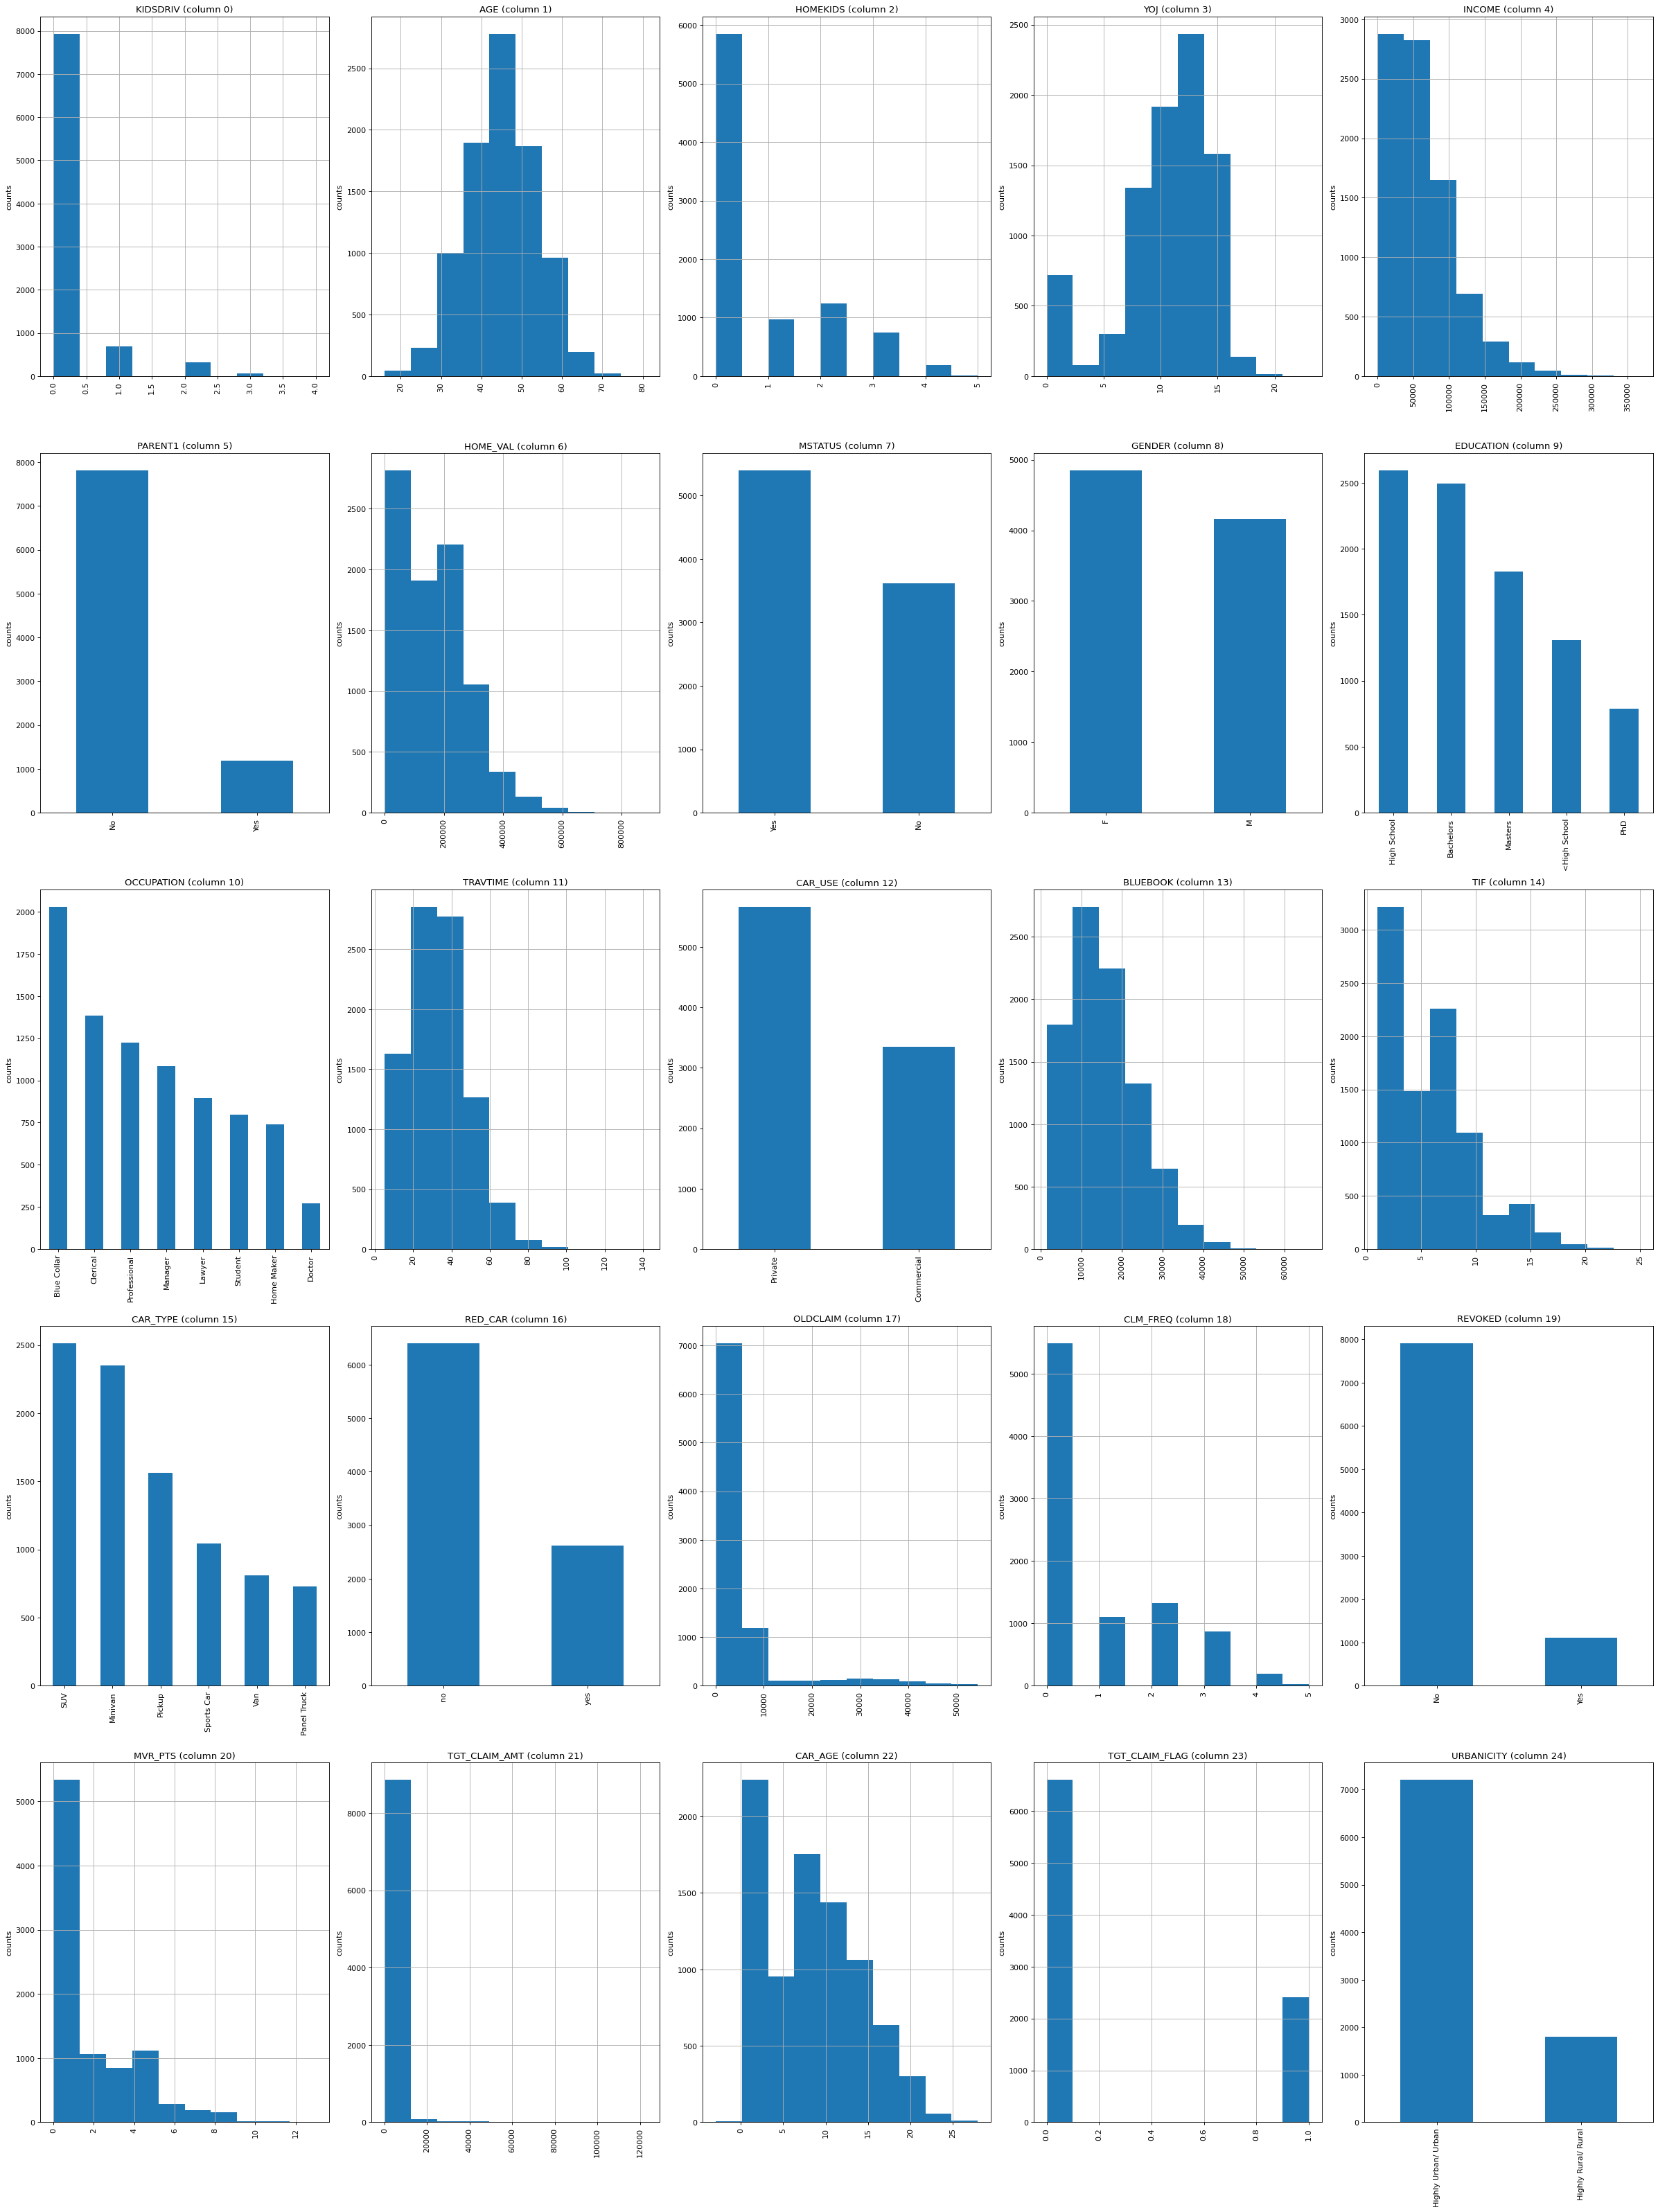

In [18]:
def plot_col_distribution(df, n_graph_per_row):
    n_col = df.shape[1]
    column_names = list(df)
    n_graph_row = (n_col + n_graph_per_row - 1) // n_graph_per_row
    plt.figure(num = None, figsize = (6 * n_graph_per_row, 8 * n_graph_row), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(n_col):
        plt.subplot(n_graph_row, n_graph_per_row, i + 1)
        column_df = df.iloc[:, i]
        if (not np.issubdtype(type(column_df.iloc[0]), np.number)):
            column_df.value_counts().plot.bar()
        else:
            column_df.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{column_names[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
    
plot_col_distribution(train_df,5)

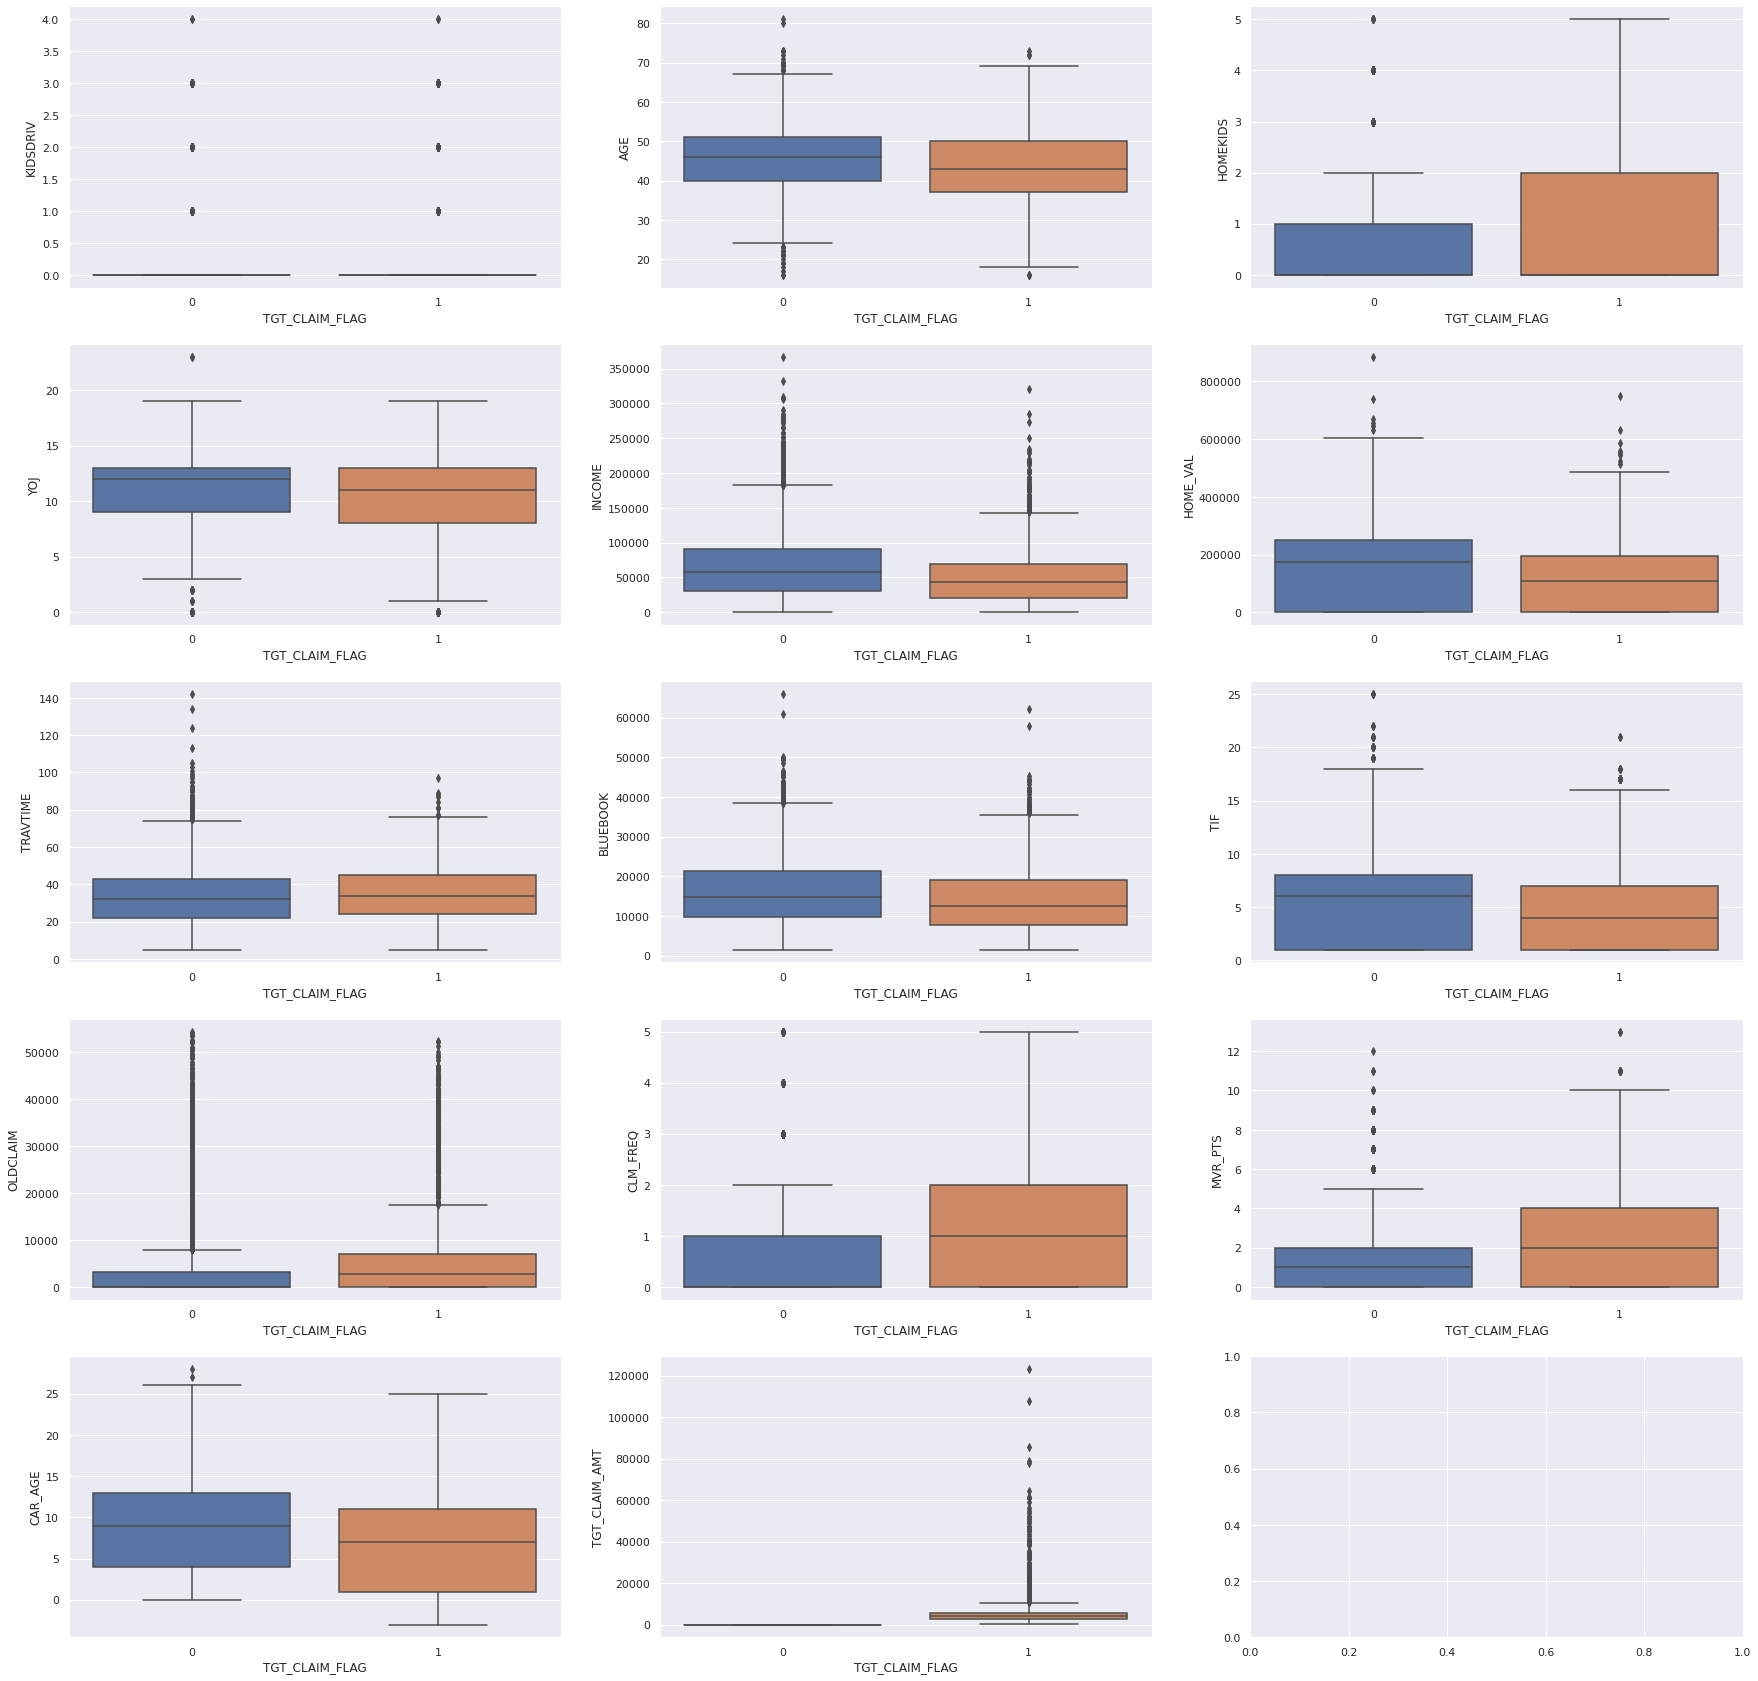

In [19]:
def plot_boxplot_by_claim_flag(df,cols,n_graph_per_row):
    sns.set_theme()
    n_rows, n_cols = 5,3
    figure, axis = plt.subplots(n_rows, n_cols, figsize = (30,30))
    i = 0
    for col in cols:
        j = i//n_cols
        k = i%n_cols
        sns.boxplot(y=col, x='TGT_CLAIM_FLAG', data=df, ax=axis[j,k])
        i +=1
        
all_num_cols = numerical_cols + ['TGT_CLAIM_AMT']
plot_boxplot_by_claim_flag(train_df,all_num_cols,5)

In [20]:
from scipy.stats import skew
for col in numerical_cols:
    print(f"{col} : {skew(train_df[col])}")
print(f"TGT_CLAIM_AMT : {skew(train_df['TGT_CLAIM_AMT'])}")

KIDSDRIV : 3.3445344199795564
AGE : nan
HOMEKIDS : 1.3346344289589562
YOJ : nan
INCOME : nan
HOME_VAL : nan
TRAVTIME : 0.4657126994407154
BLUEBOOK : 0.7487941795979247
TIF : 0.8991734137146293
OLDCLAIM : 3.098382343803341
CLM_FREQ : 1.184517827729783
MVR_PTS : 1.3447504309563114
CAR_AGE : nan
TGT_CLAIM_AMT : 9.437524837169907


There appears to be quite a bit of skew in some of the numerical variables.

However, we'll do our best to preserve the structure including outliers, so that we can make the most of it.

It's also worth noting that our regression target has a very large positive skew.

### 2.3 Checking Correlation between Variables
Understanding how the variables are related can tell us more about whether or not features are redundant. Redundant features can negatively impact the performance of the model.

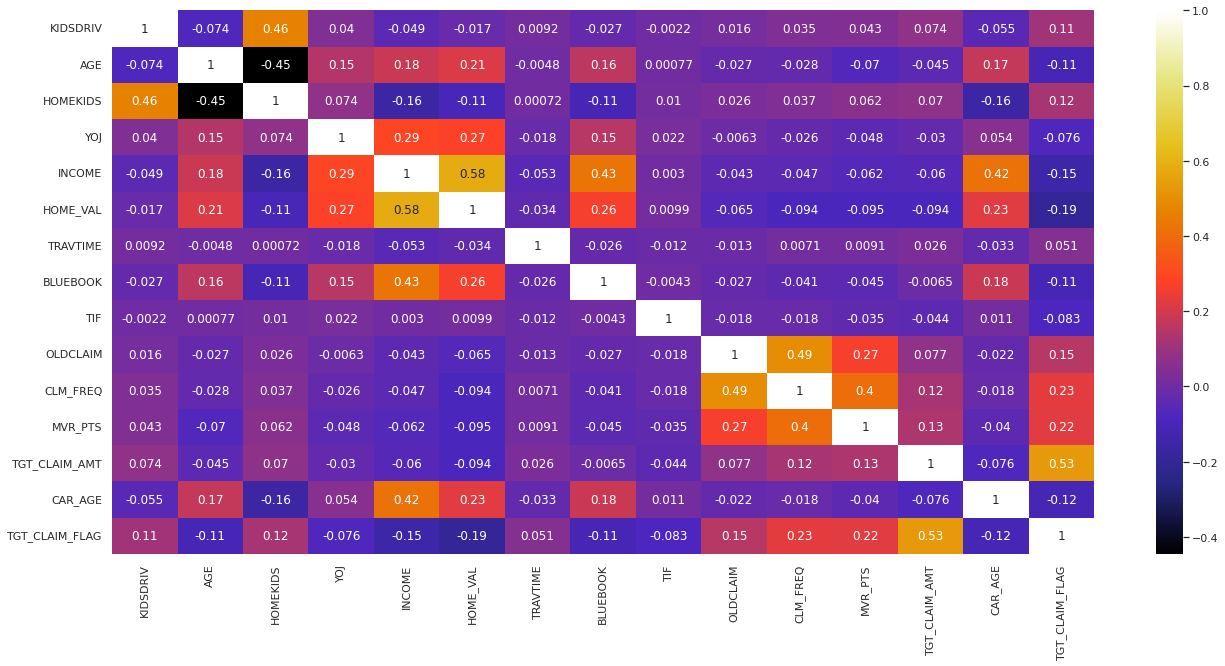

In [21]:
def plot_corr(df):
    corr = df.corr()
    sns.set_theme()
    plt.figure(figsize = (22,10))
    sns.heatmap(corr, cbar=True, annot=True, cmap='CMRmap')
plot_corr(train_df)

At a glance, most features are not generally correlated, which would be good for use in the model later.

For `'HOMEKIDS','KIDSDRIV','AGE'`, there is some correlation with each other. It makes sense that more kids at home increases the likelihood of a kid driving. Age is negatively correlated, which may suggest that only younger adults have children, and children leave their parents house relatively younger generally. See graph below:

<AxesSubplot:xlabel='AGE', ylabel='HOMEKIDS'>

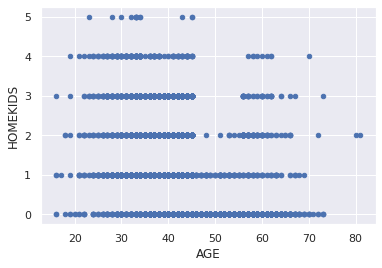

In [22]:
train_df.plot.scatter('AGE','HOMEKIDS')

There's also another hotspot with `'INCOME','HOME_VAL','BLUEBOOK','YOJ','CAR_AGE'`. High income earners tend to buy higher valued homes, and more expensive cars. They also tend to have worked more years on the job. 

Somehow, they also have older cars - a taste for classics? Or too frugal to get a new one? "Just gets me from point A to point B!"

Another cluster is `'OLDCLAIM','CLM_FREQ','MVR_PTS'`, where drivers with higher Motor Vehicle Record points tend to have more collisions and thus a history of claims. But does this necessarily mean they will do it again?

### 2.4 Number of Categories in Each Categorical Feature
Too many categories make a feature less viable as a categorical feature.

In [23]:
for col in categorical_cols:
    print(col, 'has', pop_df[col].nunique(),'unique variables')
    

PARENT1 has 2 unique variables
MSTATUS has 2 unique variables
GENDER has 2 unique variables
EDUCATION has 5 unique variables
OCCUPATION has 8 unique variables
CAR_USE has 2 unique variables
CAR_TYPE has 6 unique variables
RED_CAR has 2 unique variables
REVOKED has 2 unique variables
URBANICITY has 2 unique variables


Fortunately, all categorical featuers have a healthy number of categories - not too many.

Some with 2 unique variables can be considered binary i.e. 2 states only.

### 2.5 Check for Missing Values



In [24]:
print(f"Missing Values in DF: {train_df.isna().sum().sum()}")
print("\n")

def find_missing(df, cols:list):
    for i in cols:
        print(" - ", i, f", Missing: {df[i].isna().sum()}")
    print("\n")

print("Categorical features are:")
find_missing(train_df, categorical_cols)
print("Numerical features are:")
find_missing(train_df, numerical_cols)

print("Targets")
find_missing(train_df, ['TGT_CLAIM_FLAG','TGT_CLAIM_AMT'])

Missing Values in DF: 2623


Categorical features are:
 -  PARENT1 , Missing: 0
 -  MSTATUS , Missing: 0
 -  GENDER , Missing: 0
 -  EDUCATION , Missing: 0
 -  OCCUPATION , Missing: 582
 -  CAR_USE , Missing: 0
 -  CAR_TYPE , Missing: 0
 -  RED_CAR , Missing: 0
 -  REVOKED , Missing: 0
 -  URBANICITY , Missing: 0


Numerical features are:
 -  KIDSDRIV , Missing: 0
 -  AGE , Missing: 6
 -  HOMEKIDS , Missing: 0
 -  YOJ , Missing: 474
 -  INCOME , Missing: 501
 -  HOME_VAL , Missing: 510
 -  TRAVTIME , Missing: 0
 -  BLUEBOOK , Missing: 0
 -  TIF , Missing: 0
 -  OLDCLAIM , Missing: 0
 -  CLM_FREQ , Missing: 0
 -  MVR_PTS , Missing: 0
 -  CAR_AGE , Missing: 550


Targets
 -  TGT_CLAIM_FLAG , Missing: 0
 -  TGT_CLAIM_AMT , Missing: 0




### 2.6 Selecting Model and Metrics
##### For the classification problem with `TGT_CLAIM_FLAG`:

This is a binary classification problem.

A great metric to use in such situations is the F1-score, derived of as a "harmonic mean" of Precision and Recall ;)

##### For the regression problem with `TGT_CLAIM_AMT`:

Since we note a high skewness on the target, we'll opt for Mean Absolute Error instead of Root Mean Squared Error, since the latter penalises strongly for errors on skewed data.

# 3. Cross Validation
Here, we will begin splitting our data to perform cross-validation when training the models.

We'll use a Stratified K-fold approach once again. A new column `kfold` will be added to keep track of the samples in each fold.

For simplicity's sake, instead of stratifying on `TGT_CLAIM_FLAG` and then on `TGT_CLAIM_AMT` again, we'll assume the latter is sufficient for our purposes here.

We'll reuse the code from previously.

In [25]:
n_folds = 5
train_cv_df = make_stratified_k_folds(train_df,'TGT_CLAIM_AMT',n_folds)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [26]:
train_cv_df.shape

(9013, 26)

In [27]:
train_cv_df.columns

Index(['KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'PARENT1', 'HOME_VAL',
       'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION', 'TRAVTIME', 'CAR_USE',
       'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR', 'OLDCLAIM', 'CLM_FREQ',
       'REVOKED', 'MVR_PTS', 'TGT_CLAIM_AMT', 'CAR_AGE', 'TGT_CLAIM_FLAG',
       'URBANICITY', 'kfold'],
      dtype='object')

# 4. Feature Engineering

Looking at the first problem, which is our Binary Classification problem of whether or not a claim is made, we've decided to use a tree-based algorithm which can handle categorical variables with ease. Nevertheless, we'll still need to deal with missing values


### 4.1 Imputing Missing Values in Numerical Variables

We can always do better than naive approaches, so for features with missing values, we'll use a KNN imputation where possible, since it "interpolates" data based on what's available

KNN imputation does not work on categorical values, so we'll apply KNN on numerical features only.




In [28]:
# Define imputers we'll be using
knn_imputer = KNNImputer(n_neighbors=2)

# Function to show a sample of the missing values that will be imputed
def show_missing_head(df,cols,n=5):
    df = df[cols]
    missing = df[df.isna().any(axis=1)].head(n)
    print('These are some samples with missing values')
    display(missing)
    print('\n')
    return missing.index.to_list()

# Some boiler plate code to impute and then sense check imputed values
def imputer_with_tester(input_df, cols, imputer, test_samples):

    df = input_df[cols]
    df_imputed = pd.DataFrame(imputer.fit_transform(df))
    df_imputed.columns = df.columns
    print('The same samples with missing values imputed')
    display(df_imputed.loc[test_samples])
    
    imputed_missing_df = df_imputed[df_imputed.isna().any(axis=1)]
    print('Sense check for any empty values remaining')
    display(imputed_missing_df)
    print('The imputed df is empty:',imputed_missing_df.empty)
    print('\n')
    return df_imputed

# Find missing values and impute numerical columns
print('NUMERICAL FEATURES')
missing_num_samples = show_missing_head(train_cv_df, numerical_cols)
train_cv_df_num_imp = imputer_with_tester(train_cv_df, numerical_cols, knn_imputer, missing_num_samples)

NUMERICAL FEATURES
These are some samples with missing values


,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE
0,0,30.0,1,12.0,NaN,0.0,40,19340.0,4,1474.0,3,4,19.0
3,0,45.0,3,14.0,61952.0,252391.0,20,31010.0,6,0.0,0,1,NaN
6,0,39.0,1,6.0,56014.0,234014.0,28,23370.0,1,0.0,0,0,NaN
10,0,58.0,0,NaN,229207.0,588059.0,46,30220.0,6,11827.0,1,4,3.0
12,1,39.0,2,NaN,5645.0,0.0,13,5400.0,6,5055.0,3,0,1.0




The same samples with missing values imputed


,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE
0,0.0,30.0,1.0,12.0,47767.0,0.0,40.0,19340.0,4.0,1474.0,3.0,4.0,19.0
3,0.0,45.0,3.0,14.0,61952.0,252391.0,20.0,31010.0,6.0,0.0,0.0,1.0,10.0
6,0.0,39.0,1.0,6.0,56014.0,234014.0,28.0,23370.0,1.0,0.0,0.0,0.0,6.0
10,0.0,58.0,0.0,9.5,229207.0,588059.0,46.0,30220.0,6.0,11827.0,1.0,4.0,3.0
12,1.0,39.0,2.0,7.0,5645.0,0.0,13.0,5400.0,6.0,5055.0,3.0,0.0,1.0


Sense check for any empty values remaining


,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE


The imputed df is empty: True




### 4.2 Imputing Missing Values in Categorical Variables
With missing categorical values, we'll park them to a new category called "MISSING" and reuse the code from before

In [29]:
# Define imputers we'll be using
cat_imputer = SimpleImputer(strategy='constant', fill_value='MISSING')

# Repeat for categorical columns, with the Simple 
print('CATEGORICAL FEATURES')
missing_cat_samples = show_missing_head(train_cv_df, categorical_cols)
train_cv_df_cat_imp = imputer_with_tester(train_cv_df, categorical_cols, cat_imputer, missing_cat_samples)

CATEGORICAL FEATURES
These are some samples with missing values


,PARENT1,MSTATUS,GENDER,EDUCATION,OCCUPATION,CAR_USE,CAR_TYPE,RED_CAR,REVOKED,URBANICITY
31,No,Yes,M,Masters,NaN,Commercial,Panel Truck,yes,No,Highly Urban/ Urban
47,No,Yes,F,Masters,NaN,Private,SUV,no,No,Highly Urban/ Urban
52,No,No,M,Masters,NaN,Commercial,Panel Truck,yes,Yes,Highly Urban/ Urban
55,No,No,M,PhD,NaN,Commercial,Panel Truck,no,No,Highly Urban/ Urban
71,No,Yes,M,Masters,NaN,Commercial,Van,no,No,Highly Urban/ Urban




The same samples with missing values imputed


,PARENT1,MSTATUS,GENDER,EDUCATION,OCCUPATION,CAR_USE,CAR_TYPE,RED_CAR,REVOKED,URBANICITY
31,No,Yes,M,Masters,MISSING,Commercial,Panel Truck,yes,No,Highly Urban/ Urban
47,No,Yes,F,Masters,MISSING,Private,SUV,no,No,Highly Urban/ Urban
52,No,No,M,Masters,MISSING,Commercial,Panel Truck,yes,Yes,Highly Urban/ Urban
55,No,No,M,PhD,MISSING,Commercial,Panel Truck,no,No,Highly Urban/ Urban
71,No,Yes,M,Masters,MISSING,Commercial,Van,no,No,Highly Urban/ Urban


Sense check for any empty values remaining


,PARENT1,MSTATUS,GENDER,EDUCATION,OCCUPATION,CAR_USE,CAR_TYPE,RED_CAR,REVOKED,URBANICITY


The imputed df is empty: True




Since we imputed the two variable types separately, we should rejoin them into one big df, just like before

In [30]:
# Recombine the two dataframes, don't forget the kfold column!
train_cv_df_imp = pd.concat([train_cv_df_num_imp, train_cv_df_cat_imp, train_cv_df[['TGT_CLAIM_FLAG','TGT_CLAIM_AMT','kfold']]], axis=1)
print(train_cv_df_imp.shape)
train_cv_df_imp.head()

(9013, 26)


,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE,PARENT1,MSTATUS,GENDER,EDUCATION,OCCUPATION,CAR_USE,CAR_TYPE,RED_CAR,REVOKED,URBANICITY,TGT_CLAIM_FLAG,TGT_CLAIM_AMT,kfold
0,0.0,30.0,1.0,12.0,47767.0,0.0,40.0,19340.0,4.0,1474.0,3.0,4.0,19.0,Yes,No,M,Masters,Manager,Private,Van,yes,No,Highly Urban/ Urban,0,0.0,0.0
1,0.0,27.0,3.0,15.0,29008.0,147459.0,77.0,16500.0,1.0,0.0,0.0,0.0,1.0,No,Yes,M,<High School,Clerical,Private,Van,no,No,Highly Rural/ Rural,0,0.0,0.0
2,0.0,47.0,0.0,14.0,2825.0,91520.0,65.0,6500.0,1.0,0.0,0.0,2.0,16.0,No,Yes,F,Bachelors,Home Maker,Private,SUV,no,No,Highly Rural/ Rural,0,0.0,0.0
3,0.0,45.0,3.0,14.0,61952.0,252391.0,20.0,31010.0,6.0,0.0,0.0,1.0,10.0,Yes,No,F,<High School,Clerical,Private,Van,no,No,Highly Urban/ Urban,0,0.0,0.0
4,0.0,53.0,0.0,13.0,117854.0,0.0,5.0,6800.0,10.0,0.0,0.0,0.0,1.0,No,No,M,Masters,Lawyer,Private,Pickup,yes,No,Highly Rural/ Rural,0,0.0,0.0


Great! Now that the missing numerical and categorical values are imputed, we can move on to encoding the categorical values.

### 4.3 Encoding Categorical Variables
XGBoost also requires some form of encoding to function with categorical variables. At the time of writing this, XGBoost 1.6 has only experimental support with limited features. We'll look into encoding in detail further below.

Looking at the nunique values from the EDA, and some off-screen analysis of each categorical value, there are 3 types of encoding we will perform here.

- Ordinal category: Only Education appears to have some linkage between the classes
- Binary categories: These categories have only two classes
- Nominal categories: There are multiple classes and they do not have any relationship with one another

In [31]:
# Define what to do with each categorical column
categorical_cols_ord = ['EDUCATION']
categorical_cols_bin = ['PARENT1','MSTATUS','GENDER','CAR_USE','RED_CAR','REVOKED','URBANICITY']
categorical_cols_nom = ['CAR_TYPE', 'OCCUPATION']

# Sense check to see if we didn't miss any columns
print('All features are accounted for:',set(categorical_cols) == set(categorical_cols_ord) | set(categorical_cols_bin) | set(categorical_cols_nom))

All features are accounted for: True


In [32]:
# Set the order of 'EDUCATION' for the ordinal encoder
EDUCATION_ordinal = [['<High School','High School','Bachelors','Masters','PhD']]

# Define encoder
ordinal_encoder_EDUCATION = OrdinalEncoder(categories=EDUCATION_ordinal)
binary_encoder = OrdinalEncoder() # We'll use this sklearn module since it works for our goal of imputing binary variables here
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Take only the categorical columns
train_cv_df_imp_cat = train_cv_df_imp[categorical_cols]

# Encode each categorical type
## Ordinal categories
train_cv_df_imp_enc_cat_ord = pd.DataFrame(ordinal_encoder_EDUCATION.fit_transform(train_cv_df_imp_cat[categorical_cols_ord]))
train_cv_df_imp_enc_cat_ord.columns = train_cv_df_imp_cat[categorical_cols_ord].columns

## Binary categories
train_cv_df_imp_enc_cat_bin = pd.DataFrame(binary_encoder.fit_transform(train_cv_df_imp_cat[categorical_cols_bin]))
train_cv_df_imp_enc_cat_bin.columns = train_cv_df_imp_cat[categorical_cols_bin].columns

## Nominal categories
train_cv_df_imp_enc_cat_nom = pd.DataFrame(oh_encoder.fit_transform(train_cv_df_imp_cat[categorical_cols_nom]))
train_cv_df_imp_enc_cat_nom.columns = oh_encoder.get_feature_names_out()

# Rejoin the three sub-df's
train_cv_df_imp_enc_cat = pd.concat([train_cv_df_imp_enc_cat_ord, train_cv_df_imp_enc_cat_bin, train_cv_df_imp_enc_cat_nom], axis=1)

train_cv_df_imp_enc_cat.head()

,EDUCATION,PARENT1,MSTATUS,GENDER,CAR_USE,RED_CAR,REVOKED,URBANICITY,CAR_TYPE_Minivan,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_SUV,CAR_TYPE_Sports Car,CAR_TYPE_Van,OCCUPATION_Blue Collar,OCCUPATION_Clerical,OCCUPATION_Doctor,OCCUPATION_Home Maker,OCCUPATION_Lawyer,OCCUPATION_MISSING,OCCUPATION_Manager,OCCUPATION_Professional,OCCUPATION_Student
0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [33]:
# Re-add the targets and kfold indexes from the CV stage
train_cv_df_imp_enc = pd.concat([train_cv_df_imp[numerical_cols], train_cv_df_imp_enc_cat, train_cv_df[['TGT_CLAIM_FLAG','TGT_CLAIM_AMT','kfold']]], axis=1)
train_cv_df_imp_enc.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE,EDUCATION,PARENT1,MSTATUS,GENDER,CAR_USE,RED_CAR,REVOKED,URBANICITY,CAR_TYPE_Minivan,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_SUV,CAR_TYPE_Sports Car,CAR_TYPE_Van,OCCUPATION_Blue Collar,OCCUPATION_Clerical,OCCUPATION_Doctor,OCCUPATION_Home Maker,OCCUPATION_Lawyer,OCCUPATION_MISSING,OCCUPATION_Manager,OCCUPATION_Professional,OCCUPATION_Student,TGT_CLAIM_FLAG,TGT_CLAIM_AMT,kfold
0,0.0,30.0,1.0,12.0,47767.0,0.0,40.0,19340.0,4.0,1474.0,3.0,4.0,19.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0
1,0.0,27.0,3.0,15.0,29008.0,147459.0,77.0,16500.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2,0.0,47.0,0.0,14.0,2825.0,91520.0,65.0,6500.0,1.0,0.0,0.0,2.0,16.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
3,0.0,45.0,3.0,14.0,61952.0,252391.0,20.0,31010.0,6.0,0.0,0.0,1.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
4,0.0,53.0,0.0,13.0,117854.0,0.0,5.0,6800.0,10.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0


In [34]:
train_cv_df_imp_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9013 entries, 0 to 9012
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   KIDSDRIV                 9013 non-null   float64
 1   AGE                      9013 non-null   float64
 2   HOMEKIDS                 9013 non-null   float64
 3   YOJ                      9013 non-null   float64
 4   INCOME                   9013 non-null   float64
 5   HOME_VAL                 9013 non-null   float64
 6   TRAVTIME                 9013 non-null   float64
 7   BLUEBOOK                 9013 non-null   float64
 8   TIF                      9013 non-null   float64
 9   OLDCLAIM                 9013 non-null   float64
 10  CLM_FREQ                 9013 non-null   float64
 11  MVR_PTS                  9013 non-null   float64
 12  CAR_AGE                  9013 non-null   float64
 13  EDUCATION                9013 non-null   float64
 14  PARENT1                 


### 4.4 Dummy Variable Trap
One of the downsides of one-hot encoding is that we can fall into the Dummy Variable Trap. To avoid problems with Multicollinearity, let's look into the one-hot encoded variables.

A common practice is to drop one of the columns for each encoding, but let's evaluate how doing so reduces multicollinearity

One of the common ways to check for multicollinearity is the Variance Inflation Factor (VIF):

- VIF = 1 : Very little Multicollinearity
- VIF < 5 : Moderate Multicollinearity
- VIF > 5 : Extreme Multicollinearity (This is what we have to avoid)

In [35]:
def calc_vif(df):
    df_cols = df.columns
    vif_values = [
        variance_inflation_factor(df.values, i) for i in range(len(df_cols))
        ]
    return pd.DataFrame(zip(df_cols, vif_values),columns=['Variable','VIF'])

calc_vif(train_cv_df_imp_enc.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT','kfold'], axis=1))

/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,KIDSDRIV,1.317129
1,AGE,1.462428
2,HOMEKIDS,2.080655
3,YOJ,1.438987
4,INCOME,2.673761
5,HOME_VAL,2.143832
6,TRAVTIME,1.036408
7,BLUEBOOK,2.056376
8,TIF,1.006306
9,OLDCLAIM,1.680381


As expected, the one-hot encoded variables displayed infinite VIF, which means we have to drop one of each of the newly encoded features.

In [36]:
# Drop one of each of the "dummy variables"
train_cv_df_imp_enc_ = train_cv_df_imp_enc.drop(['CAR_TYPE_Minivan','OCCUPATION_Blue Collar'], axis=1)

# Calculate VIF again
calc_vif(train_cv_df_imp_enc_.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT','kfold'], axis=1))

,Variable,VIF
0,KIDSDRIV,1.449251
1,AGE,26.718402
2,HOMEKIDS,2.809278
3,YOJ,10.474497
4,INCOME,7.198794
5,HOME_VAL,5.268326
6,TRAVTIME,5.156099
7,BLUEBOOK,8.523708
8,TIF,2.653427
9,OLDCLAIM,2.042534


Okay, now we can see that CAR_TYPE and OCCUPATION are no longer infinite in their VIF. This confirms that we should always drop a column when doing one-hot encoding.

Perfect! Now we have imputed all our missing values, and all categorical variables have been encoded.

This will now act as our baseline dataset for model selection. Let's call it `base_df`

In [37]:
# Let's call this dataset:
base_df = train_cv_df_imp_enc_.copy()

# 5. Model Selection
We'll select a list of popular classifiers to compare how they fare with our selected metric.

The tests here will be brief without any deeper optimisation.

In [38]:
# Model selection
classifiers = [
    ('Linear SVM', LinearSVC(random_state=0, tol=1e-5)),
    ('Nearest Neighbors', KNeighborsClassifier(3)),
    ('RBF SVM', SVC(random_state=0, gamma=2, C=1)),
    ('Decision Tree', DecisionTreeClassifier(random_state=0, max_depth=5)),
    ('Random Forest', RandomForestClassifier(random_state=0, max_depth=5, n_estimators=10, max_features=1)),
    ('Neural Net', MLPClassifier(random_state=0, alpha=1, max_iter=1000)),
    ('AdaBoost', AdaBoostClassifier(random_state=0)),
    ('Naive Bayes', GaussianNB()),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('XGBoost', XGBClassifier(random_state=0)),
    ('GBM Classifier', GradientBoostingClassifier(random_state=0))
]

In [39]:
# Create a reuseable function to split for training and validation, features and target variables, based on the fold selected
def train_test_split_by_fold(df, fold, tgt):
    X = df.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT'], axis=1)
    y = df[tgt]

    X_train = X.loc[X['kfold'] != fold].drop('kfold',axis=1)
    X_valid = X.loc[X['kfold'] == fold].drop('kfold',axis=1)
    y_train = y.loc[X['kfold'] != fold]
    y_valid = y.loc[X['kfold'] == fold]
    return X_train, X_valid, y_train, y_valid

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split_by_fold(base_df,0,'TGT_CLAIM_FLAG')

performance = []
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    perf_tuple = (name, f1_score(y_valid, y_pred, average='weighted'))
    print(perf_tuple)
    performance.append(perf_tuple)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


('Linear SVM', 0.6533208766658327)
('Nearest Neighbors', 0.6669894016114928)
('RBF SVM', 0.6115017997451868)
('Decision Tree', 0.7189305292590777)
('Random Forest', 0.6158513317040819)
('Neural Net', 0.6546338131445882)
('AdaBoost', 0.7684869436918838)
('Naive Bayes', 0.7076570372367827)
('QDA', 0.7519130366104521)
('XGBoost', 0.7717263680030139)
('GBM Classifier', 0.7743130411382331)


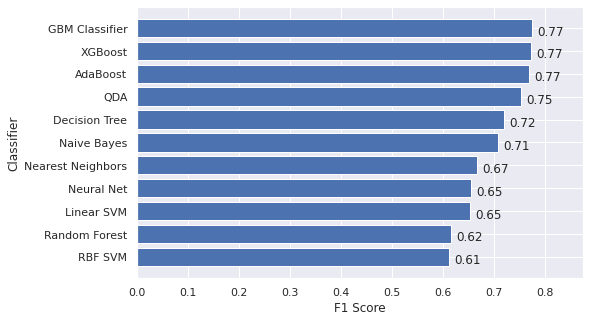

In [41]:
x, y = list(zip(*sorted(performance, key=lambda x: x[1], reverse=False)))
plt.figure(figsize=(8,5))
plt.barh(x,y)
plt.xlim(right=max(y)+0.1)
plt.xlabel('F1 Score')
plt.ylabel('Classifier')
for i in range(len(y)):
    plt.text(y[i]+0.01,i-0.3,round(y[i],2))
plt.show()

From the above, we can see clearly that all 3 of the GBM, XGBoost and AdaBoost Classifiers performed similarly. QDA is the runner up after that, but these results are enough for us to decide to proceed with a GBM variant.

Although GBM performed marginally better here, we'll use XGBoost since it's the more advanced, more tuneable algorithm.

Thus, we'll focus on performing more specific transformations to aid XGBoost.


# 6. Advanced Feature Transformations
In order to support the selected model, we should consider how to transform the dataset such that they can improve the performance of the model.

Here are some suggestions.

### 6.1 Feature Extraction
Sometimes, we can perform Feature Extraction but in our dataset, most features are straightforward and need no further extraction

### 6.2 Numerical only for XGBoost
XGBoost works with numerical data only, and fortunately our base dataframe is already encoded into numerical features.

### 6.3 Feature Scaling
Decision Tree based classifiers, which XGBoost is based on, are insensitive to scaling.

### 6.4 Feature Selection
We can reduce dimensionality but XGBoost naturally handles this usually. 

Nevertheless, let's experiment with two methods of dimensionality reduction, namely Recursive Feature Elimination (RFE) and our old friend Variance Inflation Factor (VIF)

##### 6.4.1 Recursive Feature Elimination
Let's assume a simple model (to reduce run time)[](http://), such as a Decision Tree Classifier, to help us decide which features to eliminate.

In [42]:

rfe = RFE(
estimator=DecisionTreeClassifier(),
n_features_to_select=10
)

pipe = Pipeline([('rfe',rfe)])
transformed_df_rfe = pipe.fit_transform(X_train, y_train)
support = pipe.named_steps['rfe'].support_
drop_cols_rfe = list(X_train.columns[support])

##### 6.4.2 Variance Inflation Factor Selection
Just as we have performed after the One-hot Encoding, we can perform the same selection, by removing features with a VIF greater than 5.

In [43]:
vif_df = calc_vif(X_train)
drop_cols_vif = vif_df.loc[vif_df['VIF']>5]['Variable'].values
transformed_df_rfe_vif = X_train.drop(drop_cols_vif,axis=1)
display(calc_vif(transformed_df_rfe_vif))

,Variable,VIF
0,KIDSDRIV,1.432035
1,HOMEKIDS,2.482030
2,TIF,2.371755
3,OLDCLAIM,2.039023
4,CLM_FREQ,2.284462
5,MVR_PTS,1.940147
6,PARENT1,1.967555
7,MSTATUS,2.959729
8,RED_CAR,1.701295
9,REVOKED,1.431238


Great. All remaining features have VIF under 5 now, which means they do a great job at explaining the target variable.

##### 6.4.3 Combining the two methods
Let's have a look at the list of features dropped from each of these methods.

In [44]:
print('RFE - Columns to be dropped:', list(drop_cols_rfe))
print('VIF - Columns to be dropped:', list(drop_cols_vif))


RFE - Columns to be dropped: ['AGE', 'YOJ', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK', 'TIF', 'OLDCLAIM', 'MVR_PTS', 'CAR_AGE']
VIF - Columns to be dropped: ['AGE', 'YOJ', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK', 'CAR_AGE', 'EDUCATION', 'GENDER', 'CAR_USE', 'URBANICITY']


From the two techniques, common features have been identified as not value-adding: `'AGE', 'YOJ', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK'`

So, let's remove these and test again

In [45]:
transformed_df_fs = base_df.drop(['AGE', 'YOJ', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split_by_fold(transformed_df_fs,0,'TGT_CLAIM_FLAG')

name, clf = classifiers[9]
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
perf_tuple = (name, f1_score(y_valid, y_pred, average='weighted'))
print(perf_tuple)

('XGBoost', 0.7594905265330587)


Unfortunately, dropping these features did not help improve our F1 Score. The baseline score previously was: `('XGBoost', 0.7717263680030139)`

So, despite our efforts, we'll skip feature selection and revert to the base_df

### 6.5 Log Transformation

In [46]:
high_skew_features = []

for col in numerical_cols:
    skewness = skew(base_df[col])
    asterisk = '* ' if skewness > 1 else ''
    print(f"{asterisk}{col} : {skewness}")
    if skewness > 1:
        high_skew_features.append(col)

* KIDSDRIV : 3.3445344199795564
AGE : -0.030497898234841895
* HOMEKIDS : 1.3346344289589565
YOJ : -1.1873011545395669
* INCOME : 1.147151579180837
HOME_VAL : 0.4789445155834509
TRAVTIME : 0.4657126994407153
BLUEBOOK : 0.7487941795979247
TIF : 0.899173413714629
* OLDCLAIM : 3.098382343803341
* CLM_FREQ : 1.1845178277297825
* MVR_PTS : 1.3447504309563114
CAR_AGE : 0.2796729792777843


In [47]:
transformed_df_log = base_df.copy()
for col in high_skew_features:
    transformed_df_log['log_'+col] = np.log(1 + transformed_df_log[col])

transformed_df_log.drop(high_skew_features, axis=1)
transformed_df_log.head()

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE,EDUCATION,PARENT1,MSTATUS,GENDER,CAR_USE,RED_CAR,REVOKED,URBANICITY,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_SUV,CAR_TYPE_Sports Car,CAR_TYPE_Van,OCCUPATION_Clerical,OCCUPATION_Doctor,OCCUPATION_Home Maker,OCCUPATION_Lawyer,OCCUPATION_MISSING,OCCUPATION_Manager,OCCUPATION_Professional,OCCUPATION_Student,TGT_CLAIM_FLAG,TGT_CLAIM_AMT,kfold,log_KIDSDRIV,log_HOMEKIDS,log_INCOME,log_OLDCLAIM,log_CLM_FREQ,log_MVR_PTS
0,0.0,30.0,1.0,12.0,47767.0,0.0,40.0,19340.0,4.0,1474.0,3.0,4.0,19.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.693147,10.774111,7.296413,1.386294,1.609438
1,0.0,27.0,3.0,15.0,29008.0,147459.0,77.0,16500.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.386294,10.275361,0.000000,0.000000,0.000000
2,0.0,47.0,0.0,14.0,2825.0,91520.0,65.0,6500.0,1.0,0.0,0.0,2.0,16.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.000000,7.946618,0.000000,0.000000,1.098612
3,0.0,45.0,3.0,14.0,61952.0,252391.0,20.0,31010.0,6.0,0.0,0.0,1.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.386294,11.034131,0.000000,0.000000,0.693147
4,0.0,53.0,0.0,13.0,117854.0,0.0,5.0,6800.0,10.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.000000,11.677210,0.000000,0.000000,0.000000


In [48]:
X_train, X_valid, y_train, y_valid = train_test_split_by_fold(transformed_df_log,0,'TGT_CLAIM_FLAG')

name, clf = classifiers[9]
clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
perf_tuple = (name, f1_score(y_valid, y_pred, average='weighted'))
print(perf_tuple)

('XGBoost', 0.7717263680030139)


Once again, that did not improve on our base result at all: `('XGBoost', 0.7717263680030139)`. In fact, they are exactly the same, so we'll skip this step too.

Thus, despite our best efforts at optimising the dataset, there isn't much more to be gained from this at this time. We will not be performing any extra transformations.

We'll move on to the next steps, finalising our DF as the same as what we started with.

In [49]:
final_df = base_df.copy()

# 7. Fitting the Model
To ensure our steps are all consistent and accurate, we'll use pipelines to manage all the imputing, encoding, selection and whatever transformations in between. The pipeline ensures that whatever we apply on the training set, we can also apply on the test set.

Let's build the pipeline.

In [50]:
# Redefine the imputers/encoders for the pipeline
knn_imputer = KNNImputer(n_neighbors=2)
cat_imputer = SimpleImputer(strategy='constant', fill_value='MISSING')
ordinal_encoder_EDUCATION = OrdinalEncoder(categories=EDUCATION_ordinal)
binary_encoder = OrdinalEncoder()
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first') # added drop first to skip the step of removing one of the newly encoded features

# Define transformers for numerical and categorical
numerical_transformer = knn_imputer

categorical_ord_transformer = Pipeline(steps=[
    ('cat_imputer', cat_imputer),
    ('ord', ordinal_encoder_EDUCATION),
])

categorical_bin_transformer = Pipeline(steps=[
    ('cat_imputer', cat_imputer),
    ('bin', binary_encoder),
])

categorical_ohe_transformer = Pipeline(steps=[
    ('cat_imputer', cat_imputer),
    ('nom', oh_encoder),
])

# Set out the above transformers into a ColumnTransformer class
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat_ord', categorical_ord_transformer, categorical_cols_ord),
        ('cat_bin', categorical_bin_transformer, categorical_cols_bin),
        ('cat_ohe', categorical_ohe_transformer, categorical_cols_nom)
    ])

# Define pipeline steps
base_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])

Now that we have the base pipeline, we'll cross-reference against our final_df manually built from before, to ensure the steps are repeated correctly and accurately.

In [51]:
processed_df_tmp = pd.DataFrame(base_pipeline.fit_transform(train_cv_df.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT','kfold'], axis=1)))

categorical_cols_nom_new = list(base_pipeline.named_steps['preprocessor'].transformers_[3][1].named_steps['nom'].get_feature_names_out(categorical_cols_nom))
new_cols = numerical_cols + categorical_cols_ord + categorical_cols_bin + categorical_cols_nom_new

processed_df_tmp.columns = new_cols

processed_df = pd.concat([processed_df_tmp,
    train_cv_df[['TGT_CLAIM_FLAG','TGT_CLAIM_AMT','kfold']]], axis=1)

# Validate the pipeline against the manual transforms:
print('The pipeline output is the same as the manual transform:',processed_df.equals(final_df))

The pipeline output is the same as the manual transform: True


Good. The pipeline works.

With the data from the pipeline, let's fit it to our model and see what we get.

In [52]:
# Instantiate the classifier with default parameters
xgb_clf = XGBClassifier(random_state=0)

def run_fold(df, fold, tgt, model):
    X_train, X_valid, y_train, y_valid = train_test_split_by_fold(df, fold, tgt)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    f1 = f1_score(y_valid, y_pred, average='weighted')
    print('F1 score:',f1)
    return f1

run_fold(processed_df, 0,'TGT_CLAIM_FLAG', xgb_clf)

F1 score: 0.7717263680030139


0.7717263680030139

In [53]:
def run_all_folds(df, tgt, model):
    f1_scores = []
    for fold_ in range(n_folds):
        print('Fold:',fold_ + 1, 'of', n_folds)
        f1_scores.append(run_fold(df, fold_, tgt, model))
        print('\n -----------------------------------')
    print('Average F1 Score:', np.mean(f1_scores))
    
run_all_folds(processed_df, 'TGT_CLAIM_FLAG', xgb_clf)

Fold: 1 of 5
F1 score: 0.7717263680030139

 -----------------------------------
Fold: 2 of 5
F1 score: 0.7712549422473832

 -----------------------------------
Fold: 3 of 5
F1 score: 0.767719324558236

 -----------------------------------
Fold: 4 of 5
F1 score: 0.7539330858300296

 -----------------------------------
Fold: 5 of 5
F1 score: 0.7861912006874207

 -----------------------------------
Average F1 Score: 0.7701649842652166


Great, now we've applied the same model on all folds, giving an average F1 Score as above.

Now, we'll tune our model further in the next section

# 8. Hyperparameter Optimisation

XGBoost has many parameters to tune, and in this notebook, we're not too concerned with what each parameter does. We'll use hyperopt to test the space of possible parameters, some discrete, some continuous.

We'll let the machine optimise itself.

First, let's find out the default parameters so that we can build a space of hyperparameters to test with an objective function.

In [54]:
xgb_clf.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [55]:
# Based on the defaults above, and whatever is in the documentation for XGBoost, let's define our hyperparameter test space
space = {
    'learning_rate': hp.uniform ('learning_rate', 0.05,0.5),
    'max_depth': hp.choice('max_depth', np.arange(3, 18, dtype=int)),
    'eval_metric': hp.choice('eval_metric',[None,'error']),
    'gamma': hp.uniform ('gamma', 0,9),
    'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,10),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 50, 1),
    'n_estimators': scope.int(hp.quniform('n_estimators',50,200,5))
}

The objective function outputs a loss based on the train/validation splits and the model used.

Hyperopt's fmin then minimises the loss from the objective function.

In [56]:
# Define the objective loss function to be minimised 
def objective(params):
    xgb_clf = XGBClassifier(random_state=0, **params)
    f1_scores = []
    for fold_ in range(n_folds):
        X_train, X_valid, y_train, y_valid = train_test_split_by_fold(processed_df, fold_, 'TGT_CLAIM_FLAG')

        evaluation = [(X_train, y_train), (X_valid, y_valid)]
        xgb_clf.fit(X_train, y_train,
                eval_set=evaluation,
                verbose=False)
        y_pred = xgb_clf.predict(X_valid)
        f1_scores.append(f1_score(y_valid, y_pred, average='weighted'))
    avg_f1 = np.mean(f1_scores)
#     print ("F1 Score:", avg_f1)
    return {'loss': -avg_f1, 'status': STATUS_OK }

trials = Trials()
best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)

100%|██████████| 100/100 [15:08<00:00,  9.08s/trial, best loss: -0.7910703399616121]


In [57]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7228993208693738, 'eval_metric': 0, 'gamma': 4.735717283909701, 'learning_rate': 0.09780168110572779, 'max_depth': 9, 'min_child_weight': 20.0, 'n_estimators': 135.0, 'reg_alpha': 0.0, 'reg_lambda': 8.64180358795963}


In [58]:
# Fix some values to work with XGB
best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])
best_hyperparams['eval_metric'] = [None,'error'][best_hyperparams['eval_metric']]

# Instantiate the classifier 
xgb_clf_best = XGBClassifier(random_state=0, **best_hyperparams)

run_all_folds(processed_df, 'TGT_CLAIM_FLAG', xgb_clf_best)

Fold: 1 of 5
F1 score: 0.7815466545605466

 -----------------------------------
Fold: 2 of 5
F1 score: 0.8006186384099384

 -----------------------------------
Fold: 3 of 5
F1 score: 0.7845897404511849

 -----------------------------------
Fold: 4 of 5
F1 score: 0.7713822475996736

 -----------------------------------
Fold: 5 of 5
F1 score: 0.8091653705680933

 -----------------------------------
Average F1 Score: 0.7894605303178873


Not bad! We've improved on the base model, as best as we can! XGBoost is already a pretty optimal algorithm, so we're happy with that optimisation.

In [59]:
# Add the best model to a pipeline with the base transformations
xgb_pipeline = Pipeline(steps=[
    ('base',base_pipeline),
    ('model',xgb_clf_best)
])

# 9. Predicting the Test Data
Finally, the moment of truth!

To demonstrate the pipeline in full effect, we'll use the most raw, unmodified data from the `pop_df`, where we split into the `train_df` and the `test_df`.

We'll isolate the target variables from the two datasets.

In [60]:
X_train = train_df.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT'], axis=1)
y_train = train_df['TGT_CLAIM_FLAG']
X_test = test_df.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT'], axis=1)
y_test = test_df['TGT_CLAIM_FLAG']

xgb_pipeline.fit(X_train,y_train)
y_pred = xgb_pipeline.predict(test_df)
f1_score(y_test, y_pred, average='weighted')

0.7663660237745188

Alright! F1 score on the training data is not too bad relative to what we've achieved with the training set.

Further exploration may be possible, but we're happy with this and will conclude the classification problem here.

Next, on to the regression problem.

# 10. Regression Problem

For the most part, we'll be repeating the above process, but with a regressor this time.

To begin, we may continue from the same `base_df` and `test_df`, but with the filter that `'TGT_CLAIM_FLAG' == 1`

In [61]:
base_df_r = base_df.loc[base_df['TGT_CLAIM_FLAG'] == 1]
test_df_r = test_df.loc[test_df['TGT_CLAIM_FLAG'] == 1]

### 10.1 Model Selection

Some popular regression models set out here:

In [62]:
regressors = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(random_state=0)),
    ('Logistic Regression', LogisticRegression(random_state=0, solver='sag', max_iter=20, tol=5)),
    ('Neural Network Regression ', MLPRegressor(random_state=0, alpha=1, max_iter=1000)),
    ('Lasso Regression ', Lasso(random_state=0)),
    ('Decision Tree Regression ', DecisionTreeRegressor(random_state=0, max_depth=5)),
    ('Random Forest', RandomForestRegressor(random_state=0, max_depth=5, n_estimators=10, max_features=1)),
    ('KNN Model ', KNeighborsRegressor(3)),
    ('Support Vector Machines (SVM)', SVR(gamma=2, C=1)),
    ('XGBRegressor', XGBRegressor(random_state=0))
]

In [63]:
# Split again based on new target variable
X_train, X_valid, y_train, y_valid = train_test_split_by_fold(base_df_r,0,'TGT_CLAIM_AMT')

# Test the models based on selected metric
performance = []
for name, rgr in regressors:
    rgr.fit(X_train, y_train)
    y_pred = rgr.predict(X_valid)
    perf_tuple = (name, mae(y_valid, y_pred))
    print(perf_tuple)
    performance.append(perf_tuple)

('Linear Regression', 3594.9060299353146)
('Ridge Regression', 3592.721261236622)
('Logistic Regression', 3200.6267748478704)
('Neural Network Regression ', 3815.7167881556115)
('Lasso Regression ', 3589.8546295732444)
('Decision Tree Regression ', 3698.2421778937246)
('Random Forest', 3448.901605501331)
('KNN Model ', 4609.801217038539)
('Support Vector Machines (SVM)', 3000.90892494929)
('XGBRegressor', 4233.323802893834)


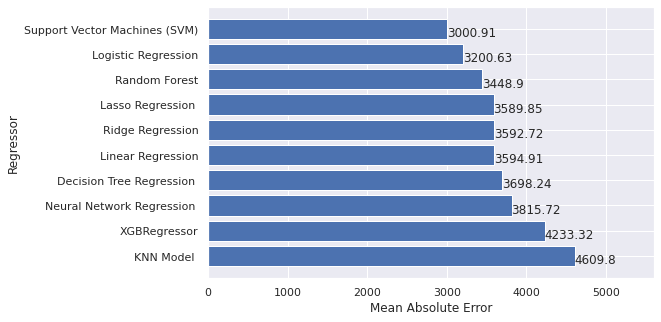

In [64]:
x, y = list(zip(*sorted(performance, key=lambda x: x[1], reverse=True)))
plt.figure(figsize=(8,5))
plt.barh(x,y)
plt.xlim(right=max(y)+1000)
plt.xlabel('Mean Absolute Error')
plt.ylabel('Regressor')
for i in range(len(y)):
    plt.text(y[i]+0.01,i-0.3,round(y[i],2))
plt.show()

SVM is the clear winner here.

### 10.2 Advanced Feature Transformation

##### 10.2.1 Dimensionality Reduction
We have a relatively low number of features compared to the number of samples. Removing any features at this point is not likely to help an SVM model.

##### 10.2.1 Scaling
Scaling may sometimes assist SVM. Let's try this. 

In [65]:
std_scl = StandardScaler()
svr = SVR(gamma=2, C=1)

svr_pipe = Pipeline(steps=[
    ('std_scl', std_scl),
    ('svm', svr)
])

X_train, X_valid, y_train, y_valid = train_test_split_by_fold(base_df_r, 0, 'TGT_CLAIM_AMT')

svr_pipe.fit(X_train, y_train)
y_pred = svr_pipe.predict(X_valid)

mae(y_valid, y_pred)

3000.909253029558

No changes to the result, so we can skip this step.

### 10.3 Fitting the Model
We'll reuse the same base pipeline, adding the SVM to it.

Since we have already done this previously, we'll skip the step and move on to optimising SVM parameters next

### 10.4 Hyperparameter Optimisation
This should be quite self explanatory at this point.


In [66]:
svr.get_params()

{'C': 1,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 2,
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [67]:
space = {
    'C': hp.uniform ('C', 0,10),
    'epsilon': hp.uniform ('epsilon', 0,10),
    'degree': hp.quniform ('degree', 0,10,1),
    'gamma': hp.uniform ('gamma', 0,10)
}

def objective(params):
    svr = SVR(**params)
    mae_scores = []
    for fold_ in range(n_folds):
        X_train, X_valid, y_train, y_valid = train_test_split_by_fold(base_df_r, 0, 'TGT_CLAIM_AMT')
        svr.fit(X_train, y_train)
        y_pred = svr.predict(X_valid)
        mae_scores.append(mae(y_valid, y_pred))
    avg_mae = np.mean(mae_scores)
#     print ("Mean Absolute Error:", avg_mae)
    return {'loss': avg_mae, 'status': STATUS_OK }    
    
trials = Trials()
best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)

100%|██████████| 100/100 [02:36<00:00,  1.57s/trial, best loss: 3000.8833671399593]


In [68]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'C': 0.47313300562417226, 'degree': 3.0, 'epsilon': 9.999305327047916, 'gamma': 3.1299086950795196}


In [69]:
# Instantiate the classifier 
svr_best = SVR(**best_hyperparams)

def run_fold(df, fold, tgt, model):
    X_train, X_valid, y_train, y_valid = train_test_split_by_fold(df, fold,tgt)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    mae_score = mae(y_valid, y_pred)
    print('Mean Absolute Error:',mae_score)
    return mae_score

def run_all_folds(df, tgt, model):
    mae_scores = []
    for fold_ in range(n_folds):
        print('Fold:',fold_ + 1, 'of', n_folds)
        mae_scores.append(run_fold(df, fold_, tgt, model))
        print('\n -----------------------------------')
    print('Average Mean Absolute Error:', np.mean(mae_scores))

run_all_folds(base_df_r, 'TGT_CLAIM_AMT', svr_best)

Fold: 1 of 5
Mean Absolute Error: 3000.8833671399593

 -----------------------------------
Fold: 2 of 5
Mean Absolute Error: 3242.776985743381

 -----------------------------------
Fold: 3 of 5
Mean Absolute Error: 3317.0354553393813

 -----------------------------------
Fold: 4 of 5
Mean Absolute Error: 2991.473220638301

 -----------------------------------
Fold: 5 of 5
Mean Absolute Error: 3156.146194420249

 -----------------------------------
Average Mean Absolute Error: 3141.6630446562544


### 10.5 Testing the Model

With the best parameters used to build the best chosen model, we'll fit it to the best pipeline, to be used to test against the test data set

In [70]:
svm_pipeline = Pipeline(steps=[
    ('base',base_pipeline),
    ('model',svr_best)
])

X_train = train_cv_df.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT','kfold'], axis=1)
y_train = train_cv_df['TGT_CLAIM_AMT']
X_test = test_df.drop(['TGT_CLAIM_FLAG','TGT_CLAIM_AMT'], axis=1)
y_test = test_df['TGT_CLAIM_AMT']

svm_pipeline.fit(X_train,y_train)
y_pred = svm_pipeline.predict(test_df)

mae(y_test, y_pred)

1472.4179758359003

Wow, that performed better than expected!

Great! That wraps up our prediction on the numerical claim amounts!

# Conclusion
Hope you've enjoyed this journey with me. I had a lot of fun writing this notebook, showing each step to as much detail as possible.

There are so many differing methodologies out there, and this one is mine.

There's probably several areas in this notebook that could have been improved upon but I wish I had more time to dive deeper into.

If you have a better suggestion on how one could improve the model, feel free to comment! I'm always open to constructive feedback on improving my work.

-----

### About the Author

Hi, I'm DL, a passionate data scientist, understanding the world through data and models.

I may be available for Data Science work and more, please feel free to leave me an email here (no spam please!): dl.biz2@outlook.com

Let's chat more if we're a good fit. Don't overfit! ;)

Always learning.